# Aruco Generation Script

In [1]:
import os
import copy
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from matplotlib import cm
from grace.utils import *

In [2]:
# Helper Functions

def mm_to_px(mm_length):
    px_length = 3.7795275591 * mm_length
    return px_length

In [3]:
# ------------------------------
# ENTER YOUR PARAMETERS HERE:
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
ARUCO_PARAMS = cv2.aruco.DetectorParameters()
aruco_idx = 0
marker_mm = 50  # mm
marker_px = round(mm_to_px(marker_mm))  # (45 mm) Get mm to px conversion in internet
# ------------------------------
print('Marker Size (px):', marker_px)

Marker Size (px): 189


# Aruco Detection

In [4]:
test_img = cv2.imread('test_aruco_detect.png')
og_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

In [5]:
corners, ids, rejected = cv2.aruco.detectMarkers(og_img, ARUCO_DICT, parameters=ARUCO_PARAMS)

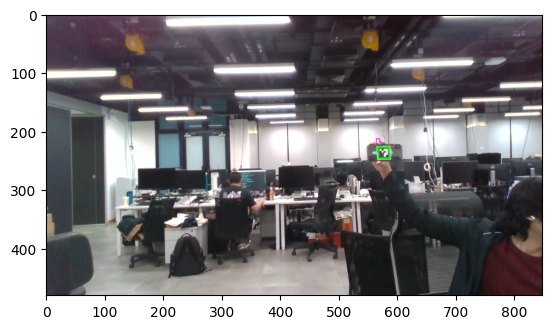

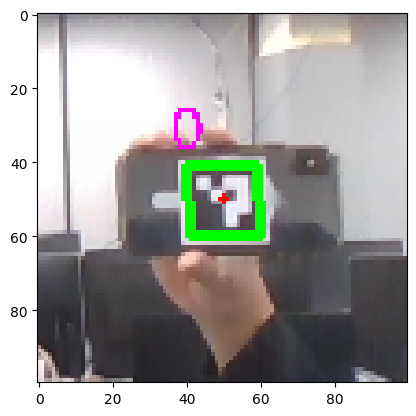

In [6]:
# Processing

image = copy.deepcopy(og_img)
if len(corners) > 0:

    for markerCorner, markerId in zip(corners, ids.flatten()):
        corners_aruco = markerCorner.reshape((4, 2))
        (topLeft, topRight, bottomRight, bottomLeft) = corners_aruco

        cv2.polylines(image, [markerCorner.astype(int)], True, (0, 255, 0), 2)

        cX = int((topLeft[0] + bottomRight[0]) / 2)
        cY = int((topLeft[1] + bottomRight[1]) / 2)

        cv2.circle(image, (cX, cY), 1, (255, 0, 0), -1)
        cv2.putText(image, str(int(markerId)),
                    (int(topLeft[0] - 5), int(topLeft[1]-5)), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 255))
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(image[int(cY)-50:int(cY)+50,int(cX)-50:int(cX)+50,:])

# Pose Detection

In [7]:
camera_mtx = load_json("config/camera/camera_mtx.json")
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

In [8]:
frame = copy.deepcopy(image)
if len(corners) > 0:
    for i in range(0, len(ids)):
        rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], 0.05,
                                                                       chest_cam_camera_mtx, 
                                                                       chest_cam_dist_coef)
        cv2.aruco.drawDetectedMarkers(frame, corners) 

        cv2.drawFrameAxes(frame, chest_cam_camera_mtx, chest_cam_dist_coef, rvec, tvec, 0.05) 

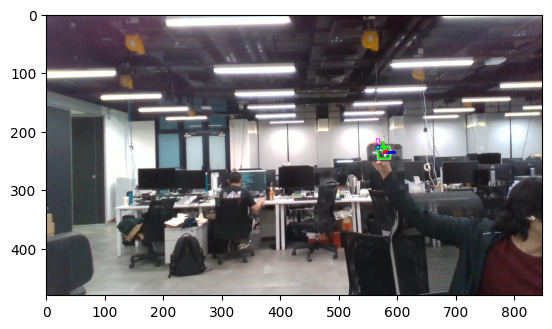

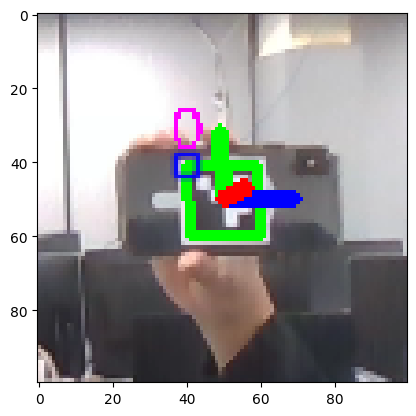

In [9]:
# Display Image

plt.figure()
plt.imshow(frame)
plt.figure()
plt.imshow(frame[int(cY)-50:int(cY)+50,int(cX)-50:int(cX)+50,:])

In [10]:
# Project Points

target_img = copy.deepcopy(frame)
# Define the 3D points to be projected
points_3d = np.array([[0.065, 0.025, 0.0]])

# Project the 3D points onto the 2D image plane
points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, chest_cam_camera_mtx, chest_cam_dist_coef)

# Display the projected 2D points
for p in points_2d:
    x, y = p.ravel()
    cv2.drawMarker(target_img, (round(x), round(y)), color=(255, 0, 0), 
                                markerType=cv2.MARKER_TILTED_CROSS, markerSize=15, thickness=2)
    print('Target Point (u,v):', x, y)

Target Point (u,v): 601.0839931321149 227.02093795178106


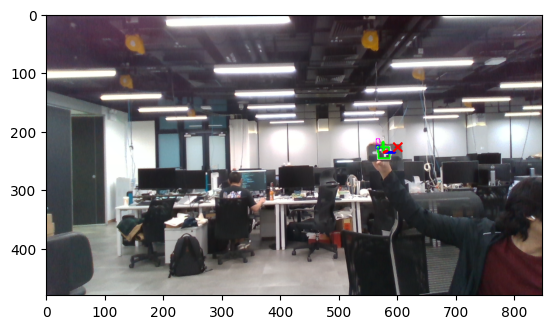

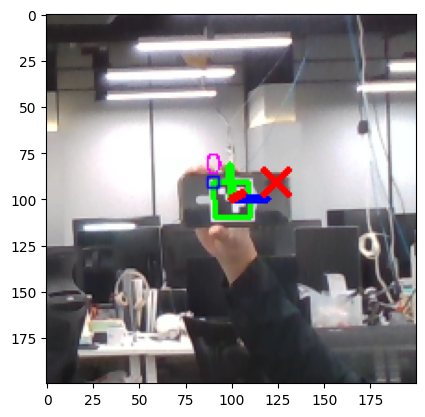

In [11]:
# Display Image

plt.figure()
plt.imshow(target_img)
plt.figure()
plt.imshow(target_img[int(cY)-100:int(cY)+100,int(cX)-100:int(cX)+100,:])